In [1]:
import scipy.stats
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf

In [2]:
# read data and select dtaa from accurate microtargeting and control conditions
df = pd.read_csv('GPTarget2024.csv')
df = df[(df['treatment_condition'] == 'microtargeting') | (df['treatment_condition'] == 'control')]

# Create dataframes split by issue
df_digital_privacy = df[df['issue_stance'] == "The U.S. should not implement legislation that strengthens digital privacy rights"]
df_renewable_energy = df[df['issue_stance'] == "The U.S. should increase investments in renewable energy technologies."]
df_china_sanctions = df[df['issue_stance'] == "The U.S. should impose stronger economic sanctions on China."]
df_nato_support = df[df['issue_stance'] == "The U.S. should not increase its support for NATO."]


In [3]:
formula = 'dv_response_mean ~ age_targeted + ethnicity_targeted + gender_targeted + education_targeted + religious_affiliation_targeted + occupation_targeted + geographic_location_targeted + party_affiliation_targeted + ideological_affiliation_targeted + political_engagement_targeted + political_party_coded + political_ideology_coded + political_engagement_coded'

# Fit the model for all issues
model = smf.ols(formula, data=df)
result = model.fit(cov_type='HC3')

# Perform the F-test
hypotheses = 'age_targeted = ethnicity_targeted = gender_targeted = education_targeted = religious_affiliation_targeted = occupation_targeted = geographic_location_targeted = party_affiliation_targeted = ideological_affiliation_targeted = political_engagement_targeted'
f_test = result.f_test(hypotheses)
f_pvalue = f_test.pvalue

print("F-test results:")
print(f_test)

F-test results:
<F test: F=0.7224967882118561, p=0.6887373647837131, df_denom=6.23e+03, df_num=9>
F-test p-value: 0.6887373647837131


In [5]:
# List of targeted covariates
targeted_covariates = [
    'age_targeted', 'ethnicity_targeted', 'gender_targeted', 'education_targeted',
    'religious_affiliation_targeted', 'occupation_targeted', 'geographic_location_targeted',
    'party_affiliation_targeted', 'ideological_affiliation_targeted', 'political_engagement_targeted'
]

# Base part of the formula that will be constant across all models
base_formula = 'dv_response_mean ~ {} + political_party_coded + political_ideology_coded + political_engagement_coded'

# Dataframes for each issue
issue_dataframes = {
    'Digital Privacy': df_digital_privacy,
    'Renewable Energy': df_renewable_energy,
    'China Sanctions': df_china_sanctions,
    'NATO Support': df_nato_support
}

# Dictionary to hold the results for each issue and targeted covariate
results = {issue: {} for issue in issue_dataframes.keys()}

# Loop through each issue and targeted covariate to fit the models
for issue, df_issue in issue_dataframes.items():
    for covariate in targeted_covariates:
        # Filter the DataFrame for the current covariate
        df_filtered = df_issue[(df_issue[covariate] == 1) | (df_issue['control'] == 1)]
        
        # Create the formula for the current covariate
        formula = base_formula.format(covariate)
        
        # Fit the model using the filtered DataFrame
        model = smf.ols(formula, data=df_filtered)
        result = model.fit(cov_type='HC3')
        
        # Store the result
        results[issue][covariate] = result

In [7]:
# Initialize an empty list to store the data
data = []

# Iterate over the results dictionary to extract the data
for issue, models_dict in results.items():
    for covariate, model in models_dict.items():
        # Extract the coefficients and the confidence intervals
        coef = model.params[covariate]  # Get the coefficient for the targeted covariate
        conf_int = model.conf_int().loc[covariate]  # Get the confidence interval for the targeted covariate
        
        # Append the data to the list
        data.append({
            'Covariate': covariate,
            'Issue': issue,
            'Coefficient': coef,
            '95% CI Lower': conf_int[0],
            '95% CI Upper': conf_int[1]
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(data)

# Add a new row to results_df for best message condition
results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'Precision-weighted Mean', 'Coefficient': 6.20, '95% CI Lower': 4.49, '95% CI Upper': 7.90}, ignore_index=True)
results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'Renewable Energy', 'Coefficient': 1.10, '95% CI Lower': -1.93, '95% CI Upper': 4.07}, ignore_index=True)
results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'Digital Privacy', 'Coefficient': 6.37, '95% CI Lower': 3.00, '95% CI Upper': 9.73}, ignore_index=True)
results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'China Sanctions', 'Coefficient': 11.94, '95% CI Lower': 8.10, '95% CI Upper': 15.79}, ignore_index=True)
results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'NATO Support', 'Coefficient': 8.37, '95% CI Lower': 4.79, '95% CI Upper': 11.94}, ignore_index=True)

/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_84125/4159601391.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'Precision-weighted Mean', 'Coefficient': 6.20, '95% CI Lower': 4.49, '95% CI Upper': 7.90}, ignore_index=True)
/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_84125/4159601391.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Covariate': 'None\n(Best Message)', 'Issue': 'Renewable Energy', 'Coefficient': 1.10, '95% CI Lower': -1.93, '95% CI Upper': 4.07}, ignore_index=True)
/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_84125/4159601391.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [8]:
# Compute and append precision-weighted means and confidence intervals to the results DataFrame

# Define the compute_weighted_stats function
def compute_weighted_stats(term, results_dict):
    coefficients = []
    standard_errors = []
    
    # Iterate over the issues and extract the coefficients and standard errors
    for issue in results_dict:
        model = results_dict[issue][term]
        coefficients.append(model.params[term])
        standard_errors.append(model.bse[term])
    
    coefficients = np.array(coefficients)
    standard_errors = np.array(standard_errors)
    
    weights = 1 / standard_errors**2
    weighted_mean = np.sum(coefficients * weights) / np.sum(weights)
    weighted_variance = 1 / np.sum(weights)
    weighted_std_error = np.sqrt(weighted_variance)
    
    z_critical = scipy.stats.norm.ppf(0.975)  # 97.5th percentile for two-tailed test
    confidence_interval = (weighted_mean - z_critical * weighted_std_error, 
                           weighted_mean + z_critical * weighted_std_error)
    
    return weighted_mean, weighted_std_error, confidence_interval

# Use the 'targeted_covariates' list 
weighted_stats = []

# Iterate over each targeted covariate to compute the weighted statistics
for covariate in targeted_covariates:
    mean, se, ci = compute_weighted_stats(covariate, results)
    weighted_stats.append({
        'Covariate': covariate,
        'Issue': 'Precision-weighted Mean',
        'Coefficient': mean,
        'SE': se,
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1]
    })

# Convert the list of dictionaries to a DataFrame
weighted_stats_df = pd.DataFrame(weighted_stats)

# Append the new DataFrame to the existing results_df
results_df = pd.concat([results_df, weighted_stats_df], ignore_index=True)

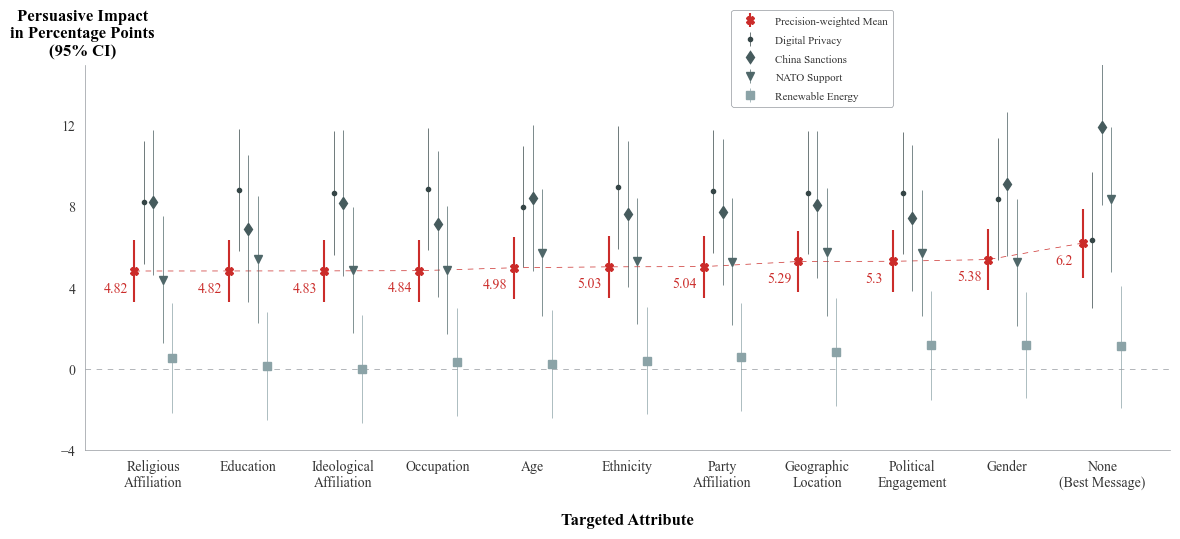

In [18]:
#FIGURE 3
# Set the font to "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

# Define constants
LABELS = ["Precision-weighted Mean", "Digital Privacy", "China Sanctions", "NATO Support", "Renewable Energy"]
COLOR_MAP = ['#CB2C2A', '#354546', '#465B5D', '#4F6769', '#8BA3A7']
MARKERS = ['X', '.', 'd', 'v', 's']

# Set the plot dimensions
fig, ax = plt.subplots(figsize=(14,5))

# Sort the DataFrame based on 'Coefficient' for 'Precision-weighted Mean' and then get unique covariates
precision_df = results_df[results_df['Issue'] == 'Precision-weighted Mean'].sort_values('Coefficient')
covariates = precision_df['Covariate'].unique()

# Use floating point numbers for the x_pos array
x_pos = np.arange(len(covariates), dtype=float) - len(LABELS)/2 * 0.1

for label, color, marker in zip(LABELS, COLOR_MAP, MARKERS):
    # Filter the dataframe for the current issue
    df_issue = results_df[results_df['Issue'] == label]
    
    # Ensure the covariates are in the correct order
    df_issue = df_issue.set_index('Covariate').loc[covariates].reset_index()
    
    # Plot coefficients with error bars and add coefficient labels
    eb = ax.errorbar(x_pos + 0.05, df_issue['Coefficient'], 
                yerr=(df_issue['Coefficient'] - df_issue['95% CI Lower'], df_issue['95% CI Upper'] - df_issue['Coefficient']), 
                fmt=marker, color=color, ecolor=color, capsize=0, label=label)

    # Change linewidth of error bars for non 'Precision-weighted Mean' labels
    if label != 'Precision-weighted Mean':
        eb[-1][0].set_linewidth(0.5)  # Here '-1' is used to access the error bar line collection
    
    # Connect points with dashed line for 'Precision-weighted Mean' only
    if label == 'Precision-weighted Mean':
        ax.plot(x_pos + 0.05, df_issue['Coefficient'], color=color, linestyle='dashed', linewidth=0.5, dashes=(8, 8))

    # Add labels below the 'Precision-weighted Mean' dots
    if label == 'Precision-weighted Mean':
        for i, coef in enumerate(df_issue['Coefficient']):
            ax.text(x_pos[i] - 0.15, coef - .85, round(coef, 2), 
                    va='center', ha='center', color=color, 
                    bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

    # Update x_pos for next plot
    x_pos += 0.1

# Configure the plot
plt.axhline(0, color='#94999E', linestyle='--', linewidth=0.5, dashes=(8, 8))
plt.ylim(-4, 15)

# ax.set_ylabel('Persuasive Impact vs. \nBest Message\n(95% CI)', fontsize=12, fontweight='bold', labelpad=17, rotation=0)
ax.text(-0.75, 16.5, 'Persuasive Impact\nin Percentage Points\n(95% CI)', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)
ax.set_xlabel('Targeted Attribute', fontsize=12, fontweight='bold', labelpad=17)
ax.set_xticks(np.arange(len(covariates)))
ax.set_xticklabels([label.replace('_targeted', '').replace('_', '\n').title() if label != 'a_13' else "None\n(Best Message)" for label in covariates], rotation=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(colors='#333333')
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(loc=(0.595, 0.890), edgecolor='#94999E')
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

# Display the plot
plt.show()

# Save the figure as a PDF
fig.savefig('figure4.pdf', format='pdf', bbox_inches='tight')